212039 - Muhammad Faizan

BSCS-8B

Task 2

VGG19 for 4-Class Image Classification

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/Dataset/DataSet'

Data Preprocessing & Loading

In [3]:
# Define standard ImageNet-style transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full dataset and split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


Load VGG19 and Modify for 4 Classes

In [4]:
# Load VGG19 model
vgg = models.vgg19(pretrained=True)

# Freeze all layers first (for transfer learning)
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace classifier for 4-class output
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 4)

vgg = vgg.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 156MB/s]


Training Function (Reusable for Transfer + Fine-Tuning)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc.append(correct / total)
        train_loss.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        correct, total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_epoch_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc.append(correct / total)
        val_loss.append(val_epoch_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_acc, val_acc, train_loss, val_loss

Transfer Learning Training (Classifier Only)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=1e-4)

print("=== Starting Transfer Learning (frozen features) ===")
train_acc1, val_acc1, train_loss1, val_loss1 = train_model(
    vgg, train_loader, val_loader, criterion, optimizer, epochs=10
)

=== Starting Transfer Learning (frozen features) ===
Epoch 1: Train Acc: 0.6979, Val Acc: 1.0000
Epoch 2: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 3: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 4: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 5: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 6: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 7: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 8: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10: Train Acc: 1.0000, Val Acc: 1.0000


 Fine-Tuning (Unfreeze last conv layers)

In [7]:
# Unfreeze last 3 convolution layers of block5
for name, param in vgg.features.named_parameters():
    if any(x in name for x in ['34', '35', '36']):  # conv5_1, conv5_2, conv5_3
        param.requires_grad = True

# Update optimizer to include new parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=1e-5)

print("=== Starting Fine-Tuning (unfrozen last conv block) ===")
train_acc2, val_acc2, train_loss2, val_loss2 = train_model(
    vgg, train_loader, val_loader, criterion, optimizer, epochs=10
)

=== Starting Fine-Tuning (unfrozen last conv block) ===
Epoch 1: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 2: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 3: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 4: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 5: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 6: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 7: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 8: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 9: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10: Train Acc: 1.0000, Val Acc: 1.0000


Plot Accuracy and Loss

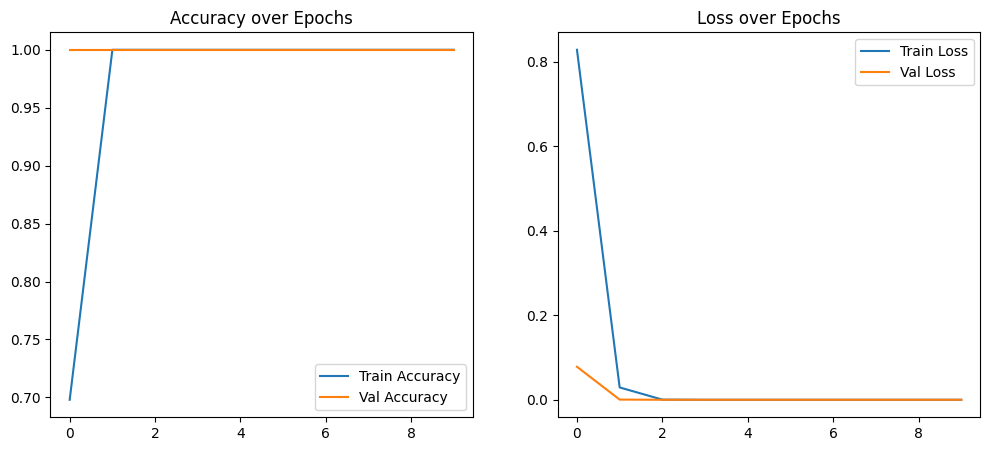

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc1, label="Train Accuracy")
plt.plot(val_acc1, label="Val Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss1, label="Train Loss")
plt.plot(val_loss1, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()


Evaluate on Test Set

Precision: 1.0
Recall (Sensitivity): 1.0
F1 Score: 1.0
Specificity per class: [np.float64(nan)]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
<ipython-input-12-1742142141>:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity.append(tn / (tn + fp))


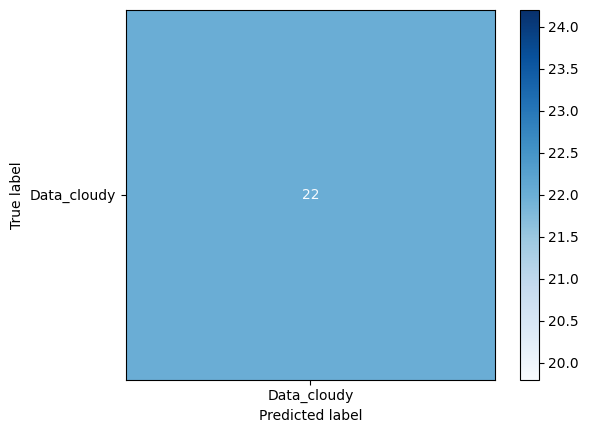

In [12]:
vgg.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vgg(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")

# Classification metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Precision:", report['weighted avg']['precision'])
print("Recall (Sensitivity):", report['weighted avg']['recall'])
print("F1 Score:", report['weighted avg']['f1-score'])

# Specificity per class
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))
print("Specificity per class:", specificity)